In [1]:
from analyse import fit_power_law, fit_bayesian_law, power_law_mapping
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import csv
import random
from tqdm import tqdm
from plotnine import ggplot, aes, geom_point, geom_line, geom_smooth, geom_boxplot, facet_wrap, stat_summary
from plotnine.scales import scale_x_log10, scale_y_log10
import math
import pandas as pd
import json


def format_token(tokenizer, tok):
    """Format the token for some path patching experiment to show decoding diff"""
    return tokenizer.decode(tok).replace(" ", "_").replace("\n", "\\n")


def top_vals(tokenizer, res, n=10, return_results=False):
    """Pretty print the top n values of a distribution over the vocabulary"""
    top_values, top_indices = torch.topk(res, n)
    ret = []
    for i, _ in enumerate(top_values):
        tok = format_token(tokenizer, top_indices[i].item())
        ret += [(tok, top_values[i].item())]
        if not return_results:
            print(f"{tok:<20} {top_values[i].item()}")
    if return_results:
        return ret


def get_logits(inputs, model, poses, mode="harmbench", tokenizer=None):
    torch.cuda.empty_cache()
    data = []
    out = model(**inputs)
    for p, pos in enumerate(poses):
        cur_pos = pos[1]
        prob = 0
        end_pos = cur_pos + 4 if mode == "harmbench" else cur_pos + 2
        for k in range(cur_pos + 1, end_pos):
            next_tok = inputs["input_ids"][0, k + 1]
            # print(format_token(tokenizer, inputs["input_ids"][0, k]), " -> ", format_token(tokenizer, next_tok))
            probs = out.logits[0, k].log_softmax(-1)
            prob -= probs[next_tok]
        data.append({"shots": p, "tokens": (cur_pos + 1).item(), "nll": prob.item(), "model": model.config._name_or_path})
    return data

In [2]:
def load_dataset(dataset="harmbench"):
    if dataset == "harmbench":
        harmbench_prompts, harmbench_answers = [], []
        with open('datasets/harmbench.csv', 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            for row in reader:
                if row[4]:
                    harmbench_prompts.append(row[0] + '\n\n' + row[4])
                else:
                    harmbench_prompts.append(row[0])
        with open('datasets/harmbench_wizardlm.csv', 'r', encoding='utf-8') as f:
            reader = csv.reader(f)
            for row in reader:
                harmbench_answers.append('Here is how ' + row[0].split(' USER:')[0].strip().split(' AUSER:')[0].strip())
        qa_pairs = list(zip(harmbench_prompts, harmbench_answers))
    elif dataset == "psychopathy":
        filename = "datasets/evals/persona/psychopathy.jsonl"
        qa_pairs = []
        with open(filename, "r") as f:
            for line in f:
                data = json.loads(line)
                qa_pairs.append((data["question"], data["answer_matching_behavior"]))
    return qa_pairs

In [3]:
with torch.inference_mode():
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    torch.cuda.empty_cache()

    # load models
    model_kwargs = {
        "torch_dtype": torch.bfloat16,
        "device_map": device,
    }
    tokenizer = AutoTokenizer.from_pretrained("google/gemma-2b-it") # same tokenizer necessary
    model = AutoModelForCausalLM.from_pretrained("google/gemma-2b-it", **model_kwargs)
    model.eval()

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
with torch.inference_mode():
    # load data
    dataset = "psychopathy"
    qa_pairs = load_dataset(dataset)
    print(len(qa_pairs))
    
    # compute NLL
    data = []
    ct = 100
    shots = 200
    trigger = 2516
    user = 1645
    for _ in tqdm(range(ct)):
        random.shuffle(qa_pairs)
        question, answer = qa_pairs[0]
        chat = []
        for j in range(shots):
            chat.append({"role": "user", "content": qa_pairs[j][0]})
            chat.append({"role": "assistant", "content": qa_pairs[j][1]})
            new_inputs = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=False)
            new_inputs = tokenizer(new_inputs, return_tensors="pt").to(device)
            if new_inputs["input_ids"].shape[-1] > 4096:
                break
            inputs = new_inputs
        # chat.append({"role": "user", "content": question})
        # chat.append({"role": "assistant", "content": answer})
        # inputs = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=False)
        # inputs = tokenizer(inputs, return_tensors="pt").to(device)
            
        poses = (inputs["input_ids"] == trigger).nonzero()
        data.extend(get_logits(inputs, model, poses, mode=dataset, tokenizer=tokenizer))

1000


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [00:51<00:00,  1.93it/s]


       shots  tokens        nll               model      prob
0          1      31   0.256211  google/gemma-2b-it  0.773978
1          2      63   3.253800  google/gemma-2b-it  0.038627
2          3     101   0.422340  google/gemma-2b-it  0.655511
3          4     133   0.119890  google/gemma-2b-it  0.887018
4          5     165  12.544294  google/gemma-2b-it  0.000004
...      ...     ...        ...                 ...       ...
12127    117    3949   0.046216  google/gemma-2b-it  0.954836
12128    118    3982   0.067779  google/gemma-2b-it  0.934467
12129    119    4011   0.900703  google/gemma-2b-it  0.406284
12130    120    4053   0.004490  google/gemma-2b-it  0.995520
12131    121    4086   0.316562  google/gemma-2b-it  0.728650

[12132 rows x 5 columns]


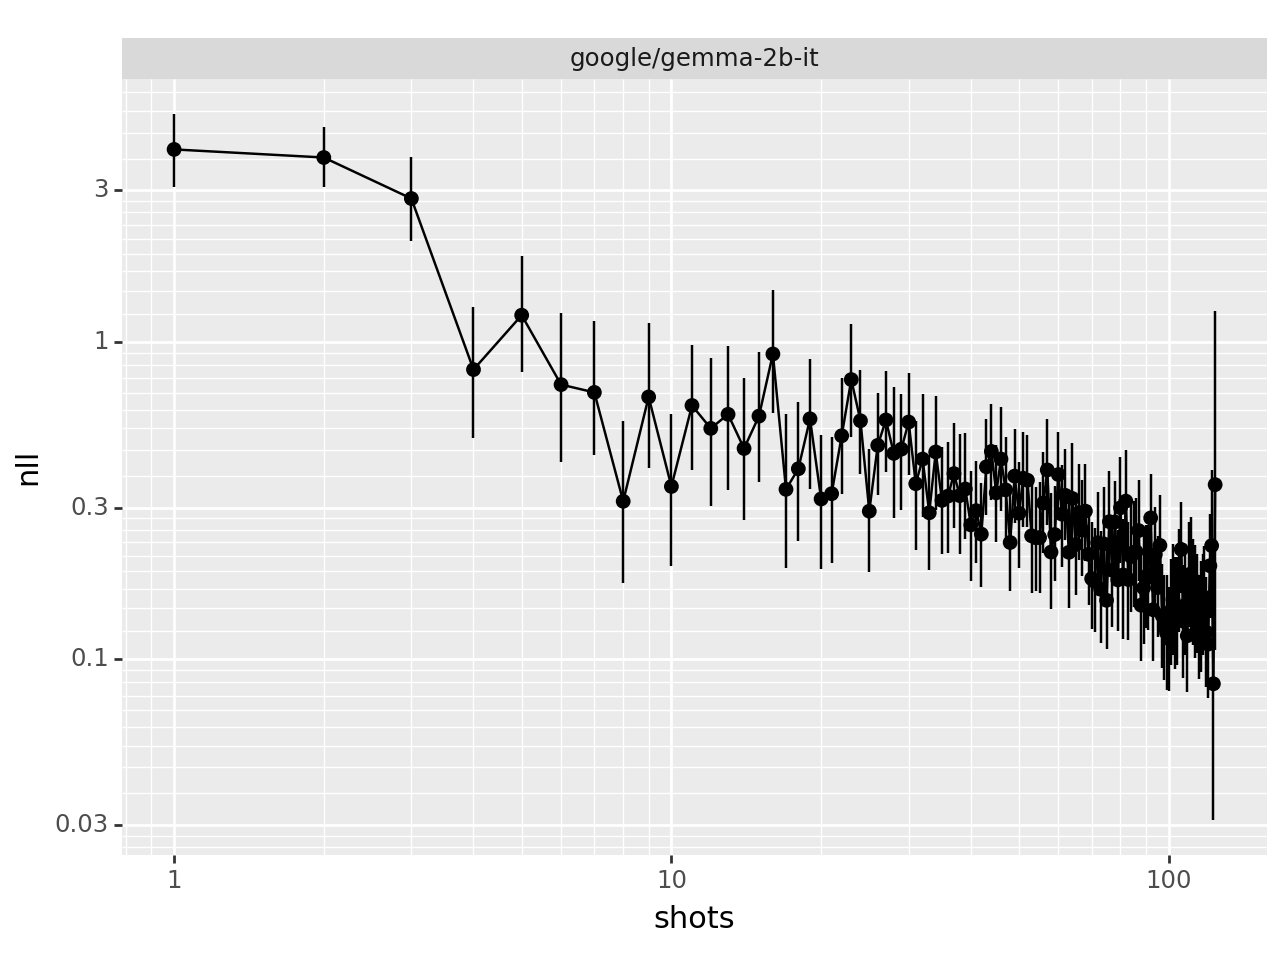

In [5]:
df = pd.DataFrame(data)
df["prob"] = df["nll"].map(lambda x: math.exp(-x))
df["shots"] += 1
print(df)

plot = (
    ggplot(df, aes(x="shots", y="nll")) +
    stat_summary(geom="line") + stat_summary() +
    # geom_point(alpha=0.5, stroke=0, size=2) +
    facet_wrap("model") + scale_x_log10() + scale_y_log10()
)
print(plot)

In [12]:
from analyse import fit_bayesian_law, fit_power_law, power_law_mapping, bayesian_law_mapping
from collections import defaultdict
from multiprocessing import Pool
import time
import numpy as np

DEVICE = "cpu"

def compute_all_fits(subset: pd.DataFrame, max_shots=1.0, i = 0):
    max_shots *= subset["shots"].max()
    models = {}
    all_params = []
    
    # fit bayesian law
    torch.manual_seed(42 + i)
    np.random.seed(42 + i)
    for law in bayesian_law_mapping.keys():
        bayesian_model = fit_bayesian_law(subset[subset["shots"] <= max_shots], False, law, quiet=False)
        models[law] = bayesian_model

    # per-hmm fits
    for hmm in range(5):
        subset_hmm = subset[subset['hmm'] == hmm]
        subset_hmm_extrapolate = subset_hmm[subset_hmm["shots"] > max_shots]
        if len(subset_hmm_extrapolate) == 0:
            subset_hmm_extrapolate = subset_hmm
        shots = torch.tensor(subset_hmm_extrapolate['shots'].values, dtype=torch.float32).to(DEVICE)
        hmms = torch.tensor(list(map(int, subset_hmm_extrapolate['hmm'].values)), dtype=torch.int32).to(DEVICE)
        true_nll = torch.tensor(subset_hmm_extrapolate['nll'].values, dtype=torch.float32).to(DEVICE)
        
        # bayesian
        for law in bayesian_law_mapping.keys():
            bayesian_model = models[law]
            more = bayesian_model.get_params()
            
            est_nll = bayesian_model(shots, hmms)
            bayesian_se = (true_nll - est_nll)**2
            bayesian_rmse = bayesian_se.mean()**0.5
            bayesian_nrmse = bayesian_rmse / (true_nll.mean())
            print(hmm, bayesian_rmse, bayesian_nrmse)
            params = {
                "hmm": hmm,
                "law": "bayesian_" + law,
                "rmse": bayesian_rmse,
                "nrmse": bayesian_nrmse,
            }
            for key in more:
                print(key, more[key])
                if key == "priors": params[key] = more[key][0][0][hmm]
                elif key == "K": params[key] = more[key][0][0]
                else: params[key] = more[key][hmm]
            all_params.append(params)

        # others
        for law in power_law_mapping.keys():
            continue
            torch.manual_seed(42 + i)
            np.random.seed(42 + i)
            model = fit_power_law(subset_hmm[subset_hmm["shots"] <= max_shots], type=law, quiet=False)
            models[(law, hmm)] = model
            est_nll = model(shots)
            power_se = (true_nll - est_nll)**2
            power_rmse = power_se.mean()**0.5
            power_nrmse = power_rmse / (true_nll.mean())
            params = {
                "hmm": hmm,
                "law": law,
                "rmse": power_rmse,
                "nrmse": power_nrmse,
            }
            params.update(model.get_params())
            all_params.append(params)

    # done
    return all_params, models

In [13]:
df["hmm"] = 0
df

,shots,tokens,nll,model,prob,hmm
0,1,31,0.256211,google/gemma-2b-it,0.773978,0
1,2,63,3.253800,google/gemma-2b-it,0.038627,0
2,3,101,0.422340,google/gemma-2b-it,0.655511,0
3,4,133,0.119890,google/gemma-2b-it,0.887018,0
4,5,165,12.544294,google/gemma-2b-it,0.000004,0
...,...,...,...,...,...,...
12127,117,3949,0.046216,google/gemma-2b-it,0.954836,0
12128,118,3982,0.067779,google/gemma-2b-it,0.934467,0
12129,119,4011,0.900703,google/gemma-2b-it,0.406284,0
12130,120,4053,0.004490,google/gemma-2b-it,0.995520,0


In [14]:
params, models = compute_all_fits(df)

 10%|███████▎                                                                 | 5/50 [00:02<00:25,  1.74it/s, loss=4.91]

0 tensor(2.2133, grad_fn=<PowBackward0>) tensor(1.6497, grad_fn=<DivBackward0>)
priors [[[1.0]]]
K [[1.0]]
P_0 [0.25969916582107544]
0 tensor(2.2135, grad_fn=<PowBackward0>) tensor(1.6500, grad_fn=<DivBackward0>)
priors [[[1.0]]]
gammas [0.2708154618740082]
betas [0.07283350080251694]
K [[1.0]]
0 tensor(2.2147, grad_fn=<PowBackward0>) tensor(1.6509, grad_fn=<DivBackward0>)
priors [[[1.0]]]
gammas [0.24099355936050415]
betas [0.06481315195560455]
K [[1.0]]
1 tensor(nan, grad_fn=<PowBackward0>) tensor(nan, grad_fn=<DivBackward0>)
priors [[[1.0]]]


IndexError: list index out of range

In [ ]:
params